In [1]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
from pulearn.elkanoto import ElkanotoPuClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.decomposition import PCA
from tqdm import tqdm

import pul_config
import importlib
importlib.reload(pul_config)

def predict_proba(m, X):
    try:
        proba = m.predict_proba(X)
    except:
        try:
            proba = m.decision_function(X)
        except:
            proba = m.best_estimator_.decision_function(X)

    return proba

def evaluate(m, X, y, n=100, scale=True):
    y_pred = m.predict(X) > 0
    y_prob_pred = predict_proba(m, X)

    order = np.argsort(y_prob_pred)[::-1]
    # print(y_pred[order][:n])
    if scale:
        return y[order][:n].sum() / y.sum()
    else:
        return y[order][:n].sum()
    

# CHANGE HERE
input_dirs = [Path('1_outputs/standard/'), Path('1_outputs/small_DS/')]
output_dirs = [Path('2_outputs/standard/'), Path('2_outputs/small_DS/')]
method = 'OneClassSVM'
pul_cfg = pul_config.OneClassSVMConfig
# -----

MODEL_NAMES = ('RotatE', 'TransE')
output_dirs = [output_dir / method for output_dir in output_dirs]

## Training

In [8]:
np.random.seed(42)

In [9]:
def train(input_dir, output_dir, n_jobs, cv, model_names, rerun=False):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    for model_name in tqdm(model_names):
        out_dir = output_dir / model_name
        out_dir.mkdir(exist_ok=True, parents=True)
        for i in tqdm(range(10)):
            m_file = out_dir / f'{model_name}_{i}.pkl'
            if m_file.exists():
                try:
                    # try to load the file
                    with open(m_file, 'rb') as f:
                        pickle.load(f)
                    if not rerun:
                        print(m_file, 'exists. Skipping...')
                        continue
                except:
                    pass

            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')

            ds_names = ('train', 'test', 'val')
            Xs = {ds: X_all[ref_df.query(ds)['id']] for ds in ds_names}
            ys = {ds: ref_df.query(ds)['y'].values for ds in ds_names}

            ds = 'train'
            X = Xs[ds]
            y = ys[ds]

            pipe = pul_cfg.build_pipeline()
            param_grid = pul_cfg.build_param_grid()

            grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, refit=True, n_jobs=n_jobs, scoring=evaluate)
            grid_search.fit(X=X, y=y)

            with open(m_file, 'wb') as f:
                pickle.dump(grid_search, f)

In [ ]:
N_JOBS = 20
CV = 5

for input_dir, output_dir in tqdm(zip(input_dirs, output_dirs), total=len(input_dirs)):
    train(input_dir=input_dir, output_dir=output_dir, model_names=MODEL_NAMES, cv=CV, n_jobs=N_JOBS)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Evaluation

In [2]:
def load_grid_searches(output_dir, model_names):
    grid_searches = {}
    for model_name in model_names:
        grid_searches[model_name] = {}
        for j in range(10):
            m_name = f'{model_name}_{j}'
            m_file = output_dir / model_name / f'{m_name}.pkl'
            with open(m_file, 'rb') as f:
                grid_search = pickle.load(f)
            grid_searches[model_name][m_name] = grid_search

    return grid_searches

In [3]:
grid_searches_list = [
    load_grid_searches(output_dir=o, model_names=MODEL_NAMES) for o in output_dirs
]

In [4]:
def score_df_from_grid_searches(grid_searches, input_dir, ns=(10,100)):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()

    score_dict = {
        'model_name': [],
        'm_name': [],
        'score10_val': [],
        'score100_val': [],
        'score10_test': [],
        'score100_test': [],

    }
    scale = False
    for model_name in grid_searches.keys():
        for i, m_name in enumerate(grid_searches[model_name].keys()):
            score_dict['model_name'].append(model_name)
            score_dict['m_name'].append(m_name)
            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')

            ds_names = ('train', 'test', 'val')
            Xs = {ds: X_all[ref_df.query(ds)['id']] for ds in ds_names}
            ys = {ds: ref_df.query(ds)['y'].values for ds in ds_names}

            grid_search = grid_searches[model_name][m_name]
            for n in ns:
                val_score = evaluate(
                    m=grid_search,
                    X=Xs['val'],
                    y=ys['val'],
                    n=n,
                    scale=scale
                )
                score_dict[f'score{n}_val'].append(val_score)

                test_score = evaluate(
                    m=grid_search,
                    X=Xs['test'],
                    y=ys['test'],
                    n=n,
                    scale=scale
                )
                score_dict[f'score{n}_test'].append(test_score)

    score_df = pd.DataFrame(score_dict)
    return score_df

In [5]:
score_dfs = [score_df_from_grid_searches(gs, i) for gs, i in zip(grid_searches_list, input_dirs)]
for output_dir, score_df in zip(output_dirs, score_dfs):
    score_df.to_csv(output_dir / 'score_df.csv')

In [16]:
score_dfs[0].groupby('model_name').mean()

/tmp/ipykernel_2820235/1470429527.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_dfs[0].groupby('model_name').mean()


,score10_val,score100_val,score10_test,score100_test
model_name,,,,
RotatE,6.4,31.0,6.6,34.9
TransE,1.1,15.5,1.3,16.8


Text(0, 0.5, 'score')

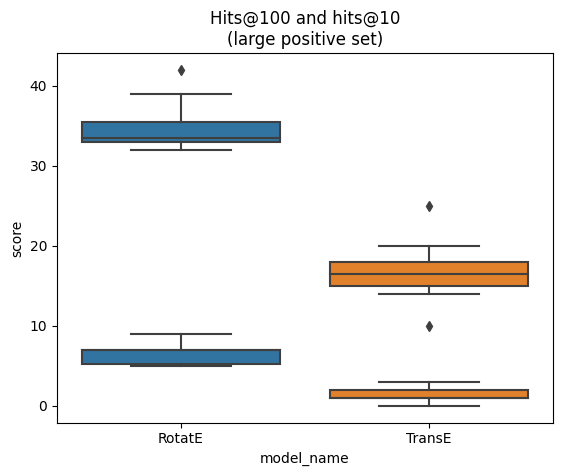

In [7]:
import seaborn as sns

sns.boxplot(score_dfs[0], x='model_name', y='score10_test').set(title='Hits@100 and hits@10\n(large positive set)')
sns.boxplot(score_dfs[0], x='model_name', y='score100_test').set_ylabel('score')

In [8]:
score_dfs[1].groupby('model_name').mean()

/tmp/ipykernel_2820235/647870589.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_dfs[1].groupby('model_name').mean()


,score10_val,score100_val,score10_test,score100_test
model_name,,,,
RotatE,1.3,11.6,2.7,14.5
TransE,3.3,18.0,1.1,16.9


Text(0, 0.5, 'score')

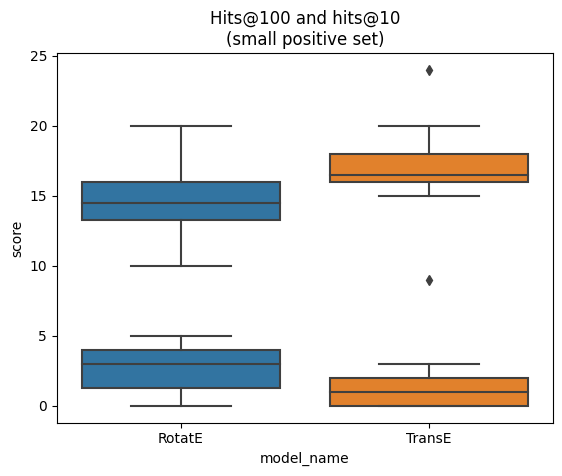

In [9]:
import seaborn as sns

sns.boxplot(score_dfs[1], x='model_name', y='score10_test').set(title='Hits@100 and hits@10\n(small positive set)')
sns.boxplot(score_dfs[1], x='model_name', y='score100_test').set_ylabel('score')

In [2]:
score_dfs = []
for output_dir in output_dirs:
    score_dfs.append(pd.read_csv(output_dir / 'score_df.csv', index_col=0))
plot_dfs = []
for ds, score_df in zip(('large', 'small'), score_dfs):
    plot_df = score_df[['model_name', 'score10_test', 'score100_test']].copy()
    plot_df.columns = ['model_name', 'hits@10', 'hits@100']
    plot_df['dataset'] = ds
    plot_dfs.append(plot_df)
    
plot_df = pd.concat(plot_dfs)
plot_df = plot_df.melt(id_vars=['model_name', 'dataset'])
plot_dfs = {k:v for k, v in plot_df.groupby('model_name')}

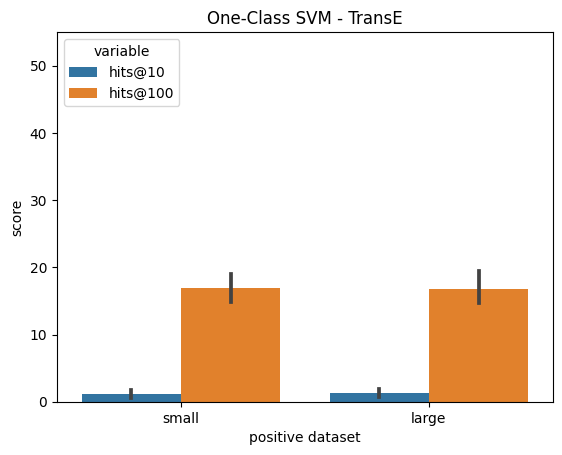

In [5]:
import seaborn as sns
model_name = 'TransE'
plot_df = plot_dfs[model_name]
plot = sns.barplot(plot_df, x='dataset', y='value', hue='variable', order=['small', 'large'])
sns.move_legend(plot, 'upper left')
plot.set(xlabel='positive dataset', ylabel='score')
plot.set_title(f'One-Class SVM - {model_name}')
plot.set_ylim([0, 55])
_ = plot.set_xticklabels(labels=['small', 'large'], rotation=0)

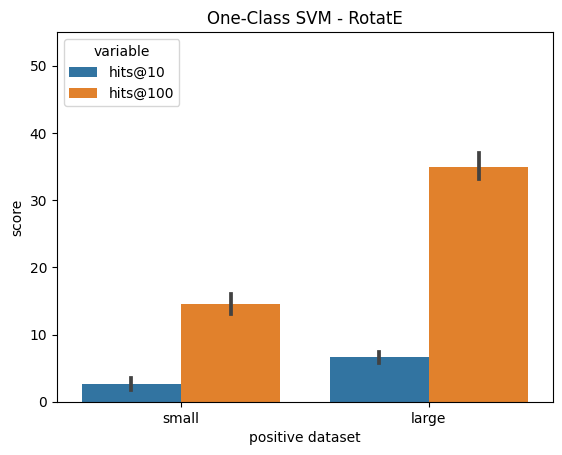

In [6]:
import seaborn as sns
model_name = 'RotatE'
plot_df = plot_dfs[model_name]
plot = sns.barplot(plot_df, x='dataset', y='value', hue='variable', order=['small', 'large'])
sns.move_legend(plot, 'upper left')
plot.set(xlabel='positive dataset', ylabel='score')
plot.set_title(f'One-Class SVM - {model_name}')
plot.set_ylim([0, 55])
_ = plot.set_xticklabels(labels=['small', 'large'], rotation=0)

In [10]:
def calc_predictions(grid_searches, input_dir):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    
    ids = ref_df['id'].values
    y = ref_df['y'].values
    train = ref_df['train'].values
    val = ref_df['val'].values
    test = ref_df['test'].values
    
    y_preds = {}
    for model_name in grid_searches.keys():
        y_preds[model_name] = {}
        for i, m_name in enumerate(grid_searches[model_name].keys()):
            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')
            X = X_all[ids]

            grid_search = grid_searches[model_name][m_name]
            y_preds[model_name][m_name] = predict_proba(grid_search, X)
            
    return y_preds

def build_proba_df(grid_searches, input_dir):
    from pykeen.datasets import OpenBioLink
    obl = OpenBioLink()
    id_to_entity = {i:e for e, i in obl.entity_to_id.items()}
    
    y_preds = calc_predictions(grid_searches=grid_searches, input_dir=input_dir)
    
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    
    ids = ref_df['id'].values
    y = ref_df['y'].values
    train = ref_df['train'].values
    val = ref_df['val'].values
    test = ref_df['test'].values
    
    proba_df = pd.DataFrame(dict(
        id=ids,
        entity=[id_to_entity[i] for i in ids],
        y=y,
        train=train,
        val=val,
        test=test,
        **y_preds['RotatE'],
        **y_preds['TransE'],
    ))
    proba_df['RotatE_sum'] = proba_df.filter(regex='RotatE_[0-9]+').sum(axis=1)
    proba_df['TransE_sum'] = proba_df.filter(regex='TransE_[0-9]+').sum(axis=1)
    
    return proba_df

In [ ]:
proba_dfs = [build_proba_df(gs, i) for gs, i in zip(grid_searches_list, input_dirs)]
for output_dir, proba_df in zip(output_dirs, proba_dfs):
    proba_df.to_csv(output_dir / 'proba_df.csv')

You're trying to map triples with 2052 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 2047 from 183011 triples were filtered out


In [ ]:
proba_df = proba_dfs[0]

In [ ]:
proba_df.query('test').sort_values('RotatE_sum', ascending=False)